# Leer datasets

In [9]:
import pandas as pd
import numpy as np

breast_cancer = pd.read_csv('../../data/real/breast-cancer-wisconsin.csv')
# drop the 'id' column
breast_cancer = breast_cancer.drop(columns=['id', 'class'])
breast_cancer["bare_nucleoli"] = pd.to_numeric(breast_cancer["bare_nucleoli"], errors='coerce')
# drop rows with NaN values
breast_cancer = breast_cancer.dropna()
print(breast_cancer.shape)
print(breast_cancer.columns)
print(breast_cancer.dtypes)
breast_cancer.head()

(683, 9)
Index(['clump_thickness', 'size_uniformity', 'shape_uniformity',
       'marginal_adhesion', 'epithelial_size', 'bare_nucleoli',
       'bland_chromatin', 'normal_nucleoli', 'mitoses'],
      dtype='object')
clump_thickness        int64
size_uniformity        int64
shape_uniformity       int64
marginal_adhesion      int64
epithelial_size        int64
bare_nucleoli        float64
bland_chromatin        int64
normal_nucleoli        int64
mitoses                int64
dtype: object


,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


# Realizamos los clusters

In [10]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 3
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.7, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(breast_cancer)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(breast_cancer)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/sklearn/cluster/_optics.py:1084: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


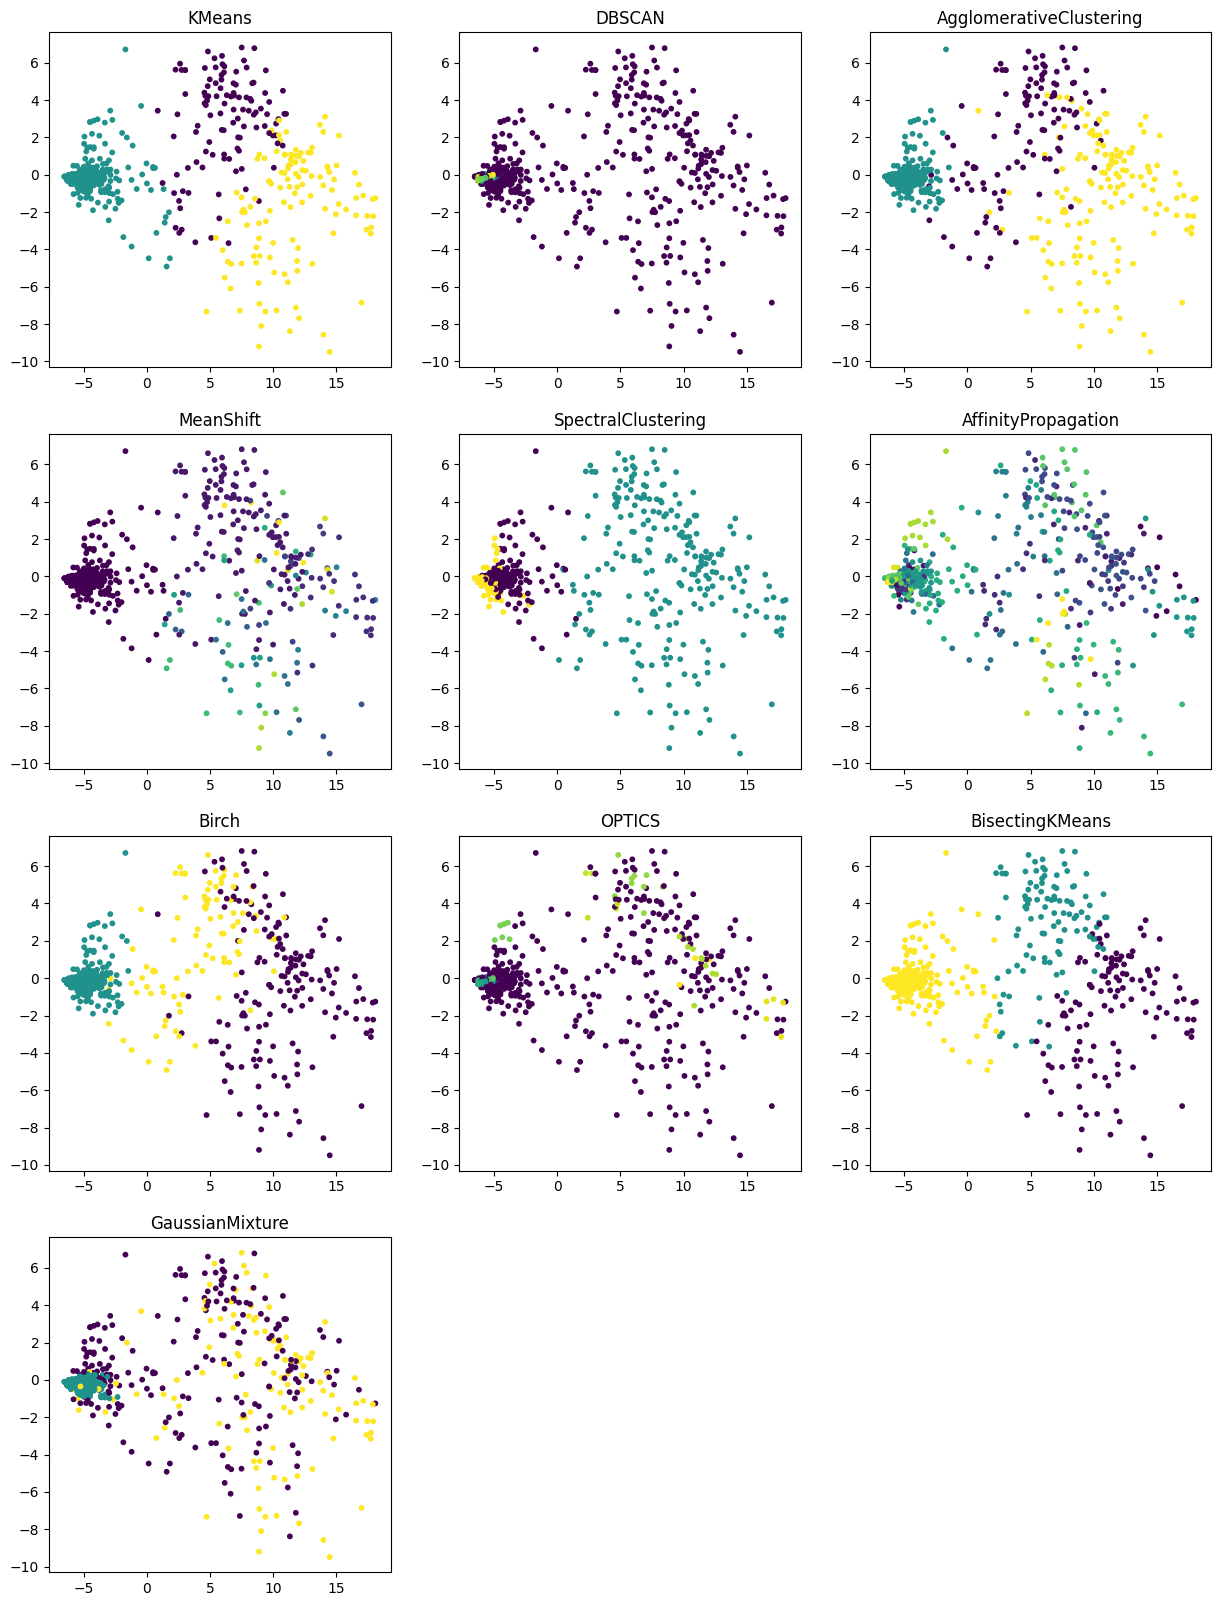

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
breast_cancer_pca = pca.fit_transform(breast_cancer)
plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(breast_cancer_pca[:, 0], breast_cancer_pca[:, 1], c=labels, cmap='viridis', s=10)
    plt.title(name)

In [12]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [13]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [14]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(breast_cancer, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/permetrics/utils/cluster_util.py:525: RuntimeWarning: invalid value encountered in divide
  result = np.mean(intra_cluster_distances / np.maximum(min_inter_cluster_distances.reshape(-1, 1), intra_cluster_distances), axis=0).mean()
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.v

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.526642,672.539963,1.539469,0.099943,0.235828,0.839232
DBSCAN,0.097411,9.715080,1.075459,0.097029,0.098375,NaN
AgglomerativeClustering,0.493975,620.011053,1.566223,0.102983,0.224009,0.878183
MeanShift,0.475384,124.069206,1.418957,0.303379,0.236909,0.970805
SpectralClustering,0.267311,544.111769,1.107380,0.045134,0.098375,0.915230
AffinityPropagation,-0.020368,37.699389,1.886523,0.000000,0.000000,NaN
Birch,0.480683,605.870147,1.577684,0.102374,0.224009,0.877305
OPTICS,-0.025278,11.104764,1.164440,0.109977,0.098375,NaN
BisectingKMeans,0.526430,668.363181,1.537634,0.098763,0.235828,0.836789
GaussianMixture,0.332779,289.405617,2.384310,0.064559,0.098375,0.984646


In [15]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
MeanShift,0.475384,124.069206,1.418957,0.303379,0.236909,0.970805,0.355288
KMeans,0.526642,672.539963,1.539469,0.099943,0.235828,0.839232,0.321691
BisectingKMeans,0.526430,668.363181,1.537634,0.098763,0.235828,0.836789,0.321468


# Interpretar

In [16]:
import sys
sys.path.append('../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [17]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = breast_cancer.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} with {n} clusters')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing MeanShift with 17 clusters


ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



Ripper Accuracy for MeanShift: 0.69
Decision Tree Accuracy for MeanShift: 0.84
Optimization started

Training time: 14.64s, epochs: 113

Least training loss reached: 0.010
DSGD Accuracy for MeanShift: 0.84
--------------------------------------------------------------------------------
Processing KMeans with 3 clusters
Ripper Accuracy for KMeans: 0.91
Decision Tree Accuracy for KMeans: 0.88
Optimization started

Training time: 21.36s, epochs: 200

Least training loss reached: 0.022
DSGD Accuracy for KMeans: 0.92
--------------------------------------------------------------------------------
Processing BisectingKMeans with 3 clusters
Ripper Accuracy for BisectingKMeans: 0.82
Decision Tree Accuracy for BisectingKMeans: 0.90
Optimization started

Training time: 21.43s, epochs: 200

Least training loss reached: 0.023
DSGD Accuracy for BisectingKMeans: 0.93
--------------------------------------------------------------------------------


# Primer algoritmo

In [18]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[size_uniformity=1] V [epithelial_size=2^bare_nucleoli=1.0] V [shape_uniformity=2] V [size_uniformity=2] V [size_uniformity=3^epithelial_size=2] V [normal_nucleoli=1^size_uniformity=3]]

Reglas para clase: 1
[[bare_nucleoli=10.0^size_uniformity=4] V [bare_nucleoli=10.0^marginal_adhesion=6] V [bare_nucleoli=10.0^size_uniformity=6] V [bare_nucleoli=10.0^size_uniformity=3] V [bland_chromatin=7^normal_nucleoli=8] V [shape_uniformity=5] V [bare_nucleoli=8.0^shape_uniformity=7] V [bland_chromatin=7^size_uniformity=5] V [shape_uniformity=6^bare_nucleoli=10.0] V [size_uniformity=4^bare_nucleoli=7.0] V [mitoses=3^epithelial_size=3] V [normal_nucleoli=4^marginal_adhesion=1] V [epithelial_size=4^clump_thickness=8] V [epithelial_size=4^marginal_adhesion=3] V [bare_nucleoli=9.0^size_uniformity=4]]

Reglas para clase: 2
[[shape_uniformity=10^marginal_adhesion=10^clump_thickness=8] V [shape_uniformity=10^marginal_adhesion=10^bare_nucleoli=10.0] V [shape_uniformity

Decision Tree:


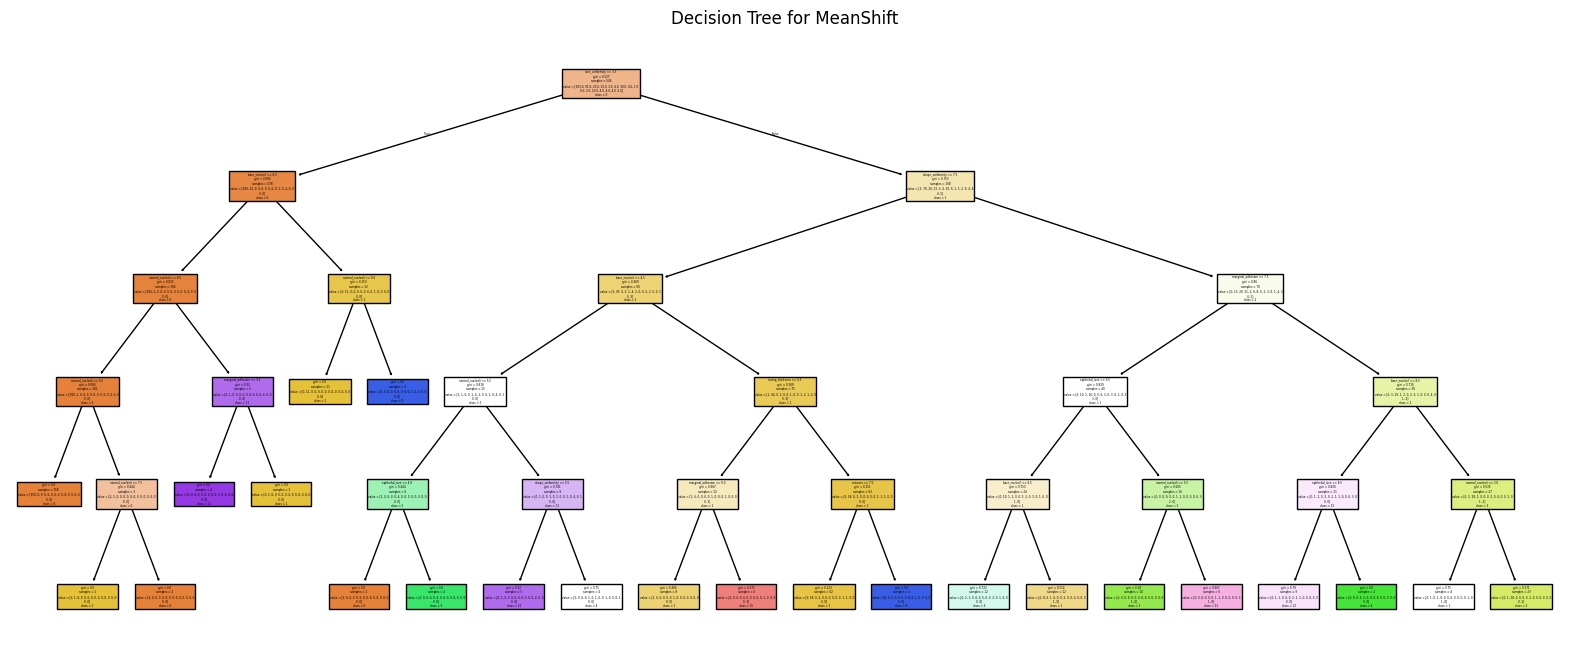

In [19]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=breast_cancer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [20]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.583] R14: 2.824 < marginal_adhesion < 4.750
			0: 0.364	1: 0.404	2: 0.000	3: 0.000	4: 0.000	5: 0.000	6: 0.005	7: 0.049	8: 0.000	9: 0.110	10: 0.000	11: 0.000	12: 0.000	13: 0.000	14: 0.000	15: 0.000	16: 0.000	Unc: 0.068

	[0.566] R34: 1.553 < mitoses < 2.653
			0: 0.379	1: 0.466	2: 0.000	3: 0.000	4: 0.000	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.000	13: 0.000	14: 0.000	15: 0.000	16: 0.000	Unc: 0.155

	[0.527] R9: 1.167 < shape_uniformity < 3.212
			0: 0.361	1: 0.376	2: 0.000	3: 0.000	4: 0.000	5: 0.000	6: 0.000	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.033	12: 0.000	13: 0.000	14: 0.000	15: 0.000	16: 0.000	Unc: 0.231

	[0.496] R2: 4.416 < clump_thickness < 6.277
			0: 0.312	1: 0.271	2: 0.008	3: 0.021	4: 0.000	5: 0.000	6: 0.010	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.168	12: 0.000	13: 0.000	14: 0.000	15: 0.000	16: 0.000	Unc: 0.210

	[0.491] R33: 0.453 < mitoses < 1.553
			0: 0.415	1: 0.166	2: 0.000	3: 0.00

# Segundo algoritmo

In [21]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[bare_nucleoli=10.0^normal_nucleoli=1] V [bare_nucleoli=10.0^size_uniformity=4] V [size_uniformity=5] V [bare_nucleoli=10.0^size_uniformity=3] V [epithelial_size=4^shape_uniformity=4] V [bare_nucleoli=10.0^normal_nucleoli=4] V [bare_nucleoli=8.0] V [clump_thickness=10^size_uniformity=3] V [epithelial_size=4^size_uniformity=6] V [shape_uniformity=5^bare_nucleoli=3.0] V [size_uniformity=4^clump_thickness=7] V [bare_nucleoli=10.0^normal_nucleoli=2] V [normal_nucleoli=3^clump_thickness=10] V [epithelial_size=4^shape_uniformity=2]]

Reglas para clase: 1
[[size_uniformity=1^bare_nucleoli=1.0] V [epithelial_size=2^bare_nucleoli=1.0] V [marginal_adhesion=1^normal_nucleoli=1] V [epithelial_size=2^bare_nucleoli=2.0] V [shape_uniformity=1] V [bland_chromatin=1] V [bare_nucleoli=1.0^size_uniformity=4] V [epithelial_size=1]]

Reglas para clase: 2
[[size_uniformity=10] V [normal_nucleoli=10] V [size_uniformity=8] V [normal_nucleoli=7] V [epithelial_size=10] V [ep

Decision Tree:


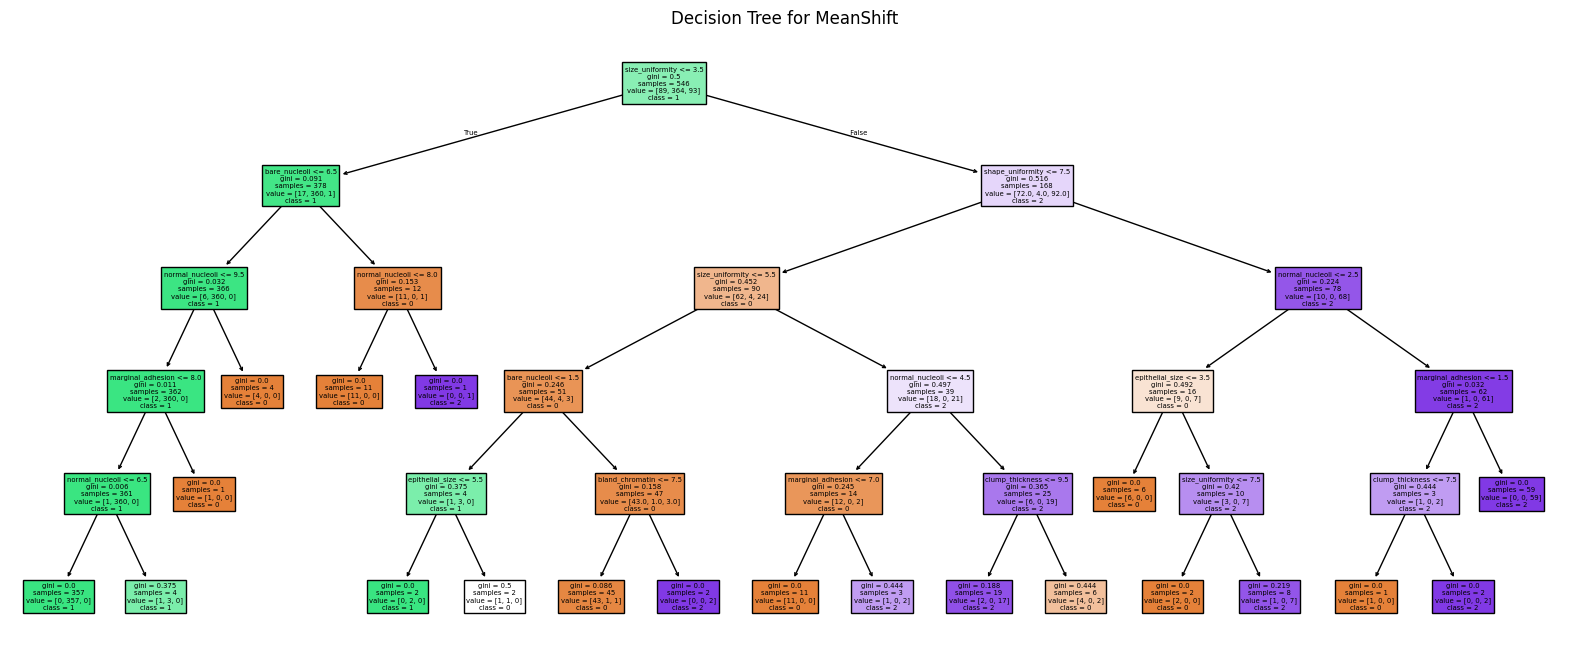

In [22]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=breast_cancer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [23]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.679] R23: bare_nucleoli > 5.915
			0: 0.679	1: 0.000	2: 0.000	Unc: 0.321

	[0.646] R26: 3.315 < bland_chromatin < 4.921
			0: 0.626	1: 0.000	2: 0.042	Unc: 0.333

	[0.582] R9: 1.167 < shape_uniformity < 3.212
			0: 0.412	1: 0.412	2: 0.000	Unc: 0.176

	[0.578] R27: bland_chromatin > 4.921
			0: 0.397	1: 0.000	2: 0.443	Unc: 0.160

	[0.571] R34: 1.553 < mitoses < 2.653
			0: 0.459	1: 0.250	2: 0.000	Unc: 0.291

	[0.566] R3: clump_thickness > 6.277
			0: 0.484	1: 0.000	2: 0.177	Unc: 0.338

	[0.549] R18: 3.185 < epithelial_size < 4.654
			0: 0.492	1: 0.000	2: 0.122	Unc: 0.386

	[0.539] R10: 3.212 < shape_uniformity < 5.258
			0: 0.520	1: 0.039	2: 0.000	Unc: 0.441

	[0.534] R6: 3.106 < size_uniformity < 5.166
			0: 0.532	1: 0.005	2: 0.000	Unc: 0.464

	[0.483] R14: 2.824 < marginal_adhesion < 4.750
			0: 0.315	1: 0.426	2: 0.000	Unc: 0.260

	[0.367] R30: 2.753 < normal_nucleoli < 4.740
			0: 0.313	1: 0.113	2: 0.005	Unc: 0.570

Most important ru

# Tercer algoritmo

In [24]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[size_uniformity=10^shape_uniformity=10] V [normal_nucleoli=10^epithelial_size=6] V [size_uniformity=8^normal_nucleoli=8] V [normal_nucleoli=10^clump_thickness=8] V [bland_chromatin=10] V [bare_nucleoli=10.0^normal_nucleoli=10] V [normal_nucleoli=7^clump_thickness=10] V [shape_uniformity=10] V [size_uniformity=10^shape_uniformity=8] V [epithelial_size=10] V [shape_uniformity=8^clump_thickness=1] V [bland_chromatin=8^normal_nucleoli=9] V [epithelial_size=7^normal_nucleoli=5] V [marginal_adhesion=9]]

Reglas para clase: 1
[[bare_nucleoli=10.0^normal_nucleoli=1] V [bare_nucleoli=10.0^size_uniformity=4] V [bare_nucleoli=10.0^epithelial_size=4^size_uniformity=5] V [shape_uniformity=5^size_uniformity=3] V [bland_chromatin=7^size_uniformity=6] V [size_uniformity=5^epithelial_size=3] V [normal_nucleoli=4^bare_nucleoli=10.0] V [size_uniformity=4] V [bland_chromatin=4^normal_nucleoli=3] V [bare_nucleoli=8.0^bland_chromatin=4] V [mitoses=2^marginal_adhesion=2]

Decision Tree:


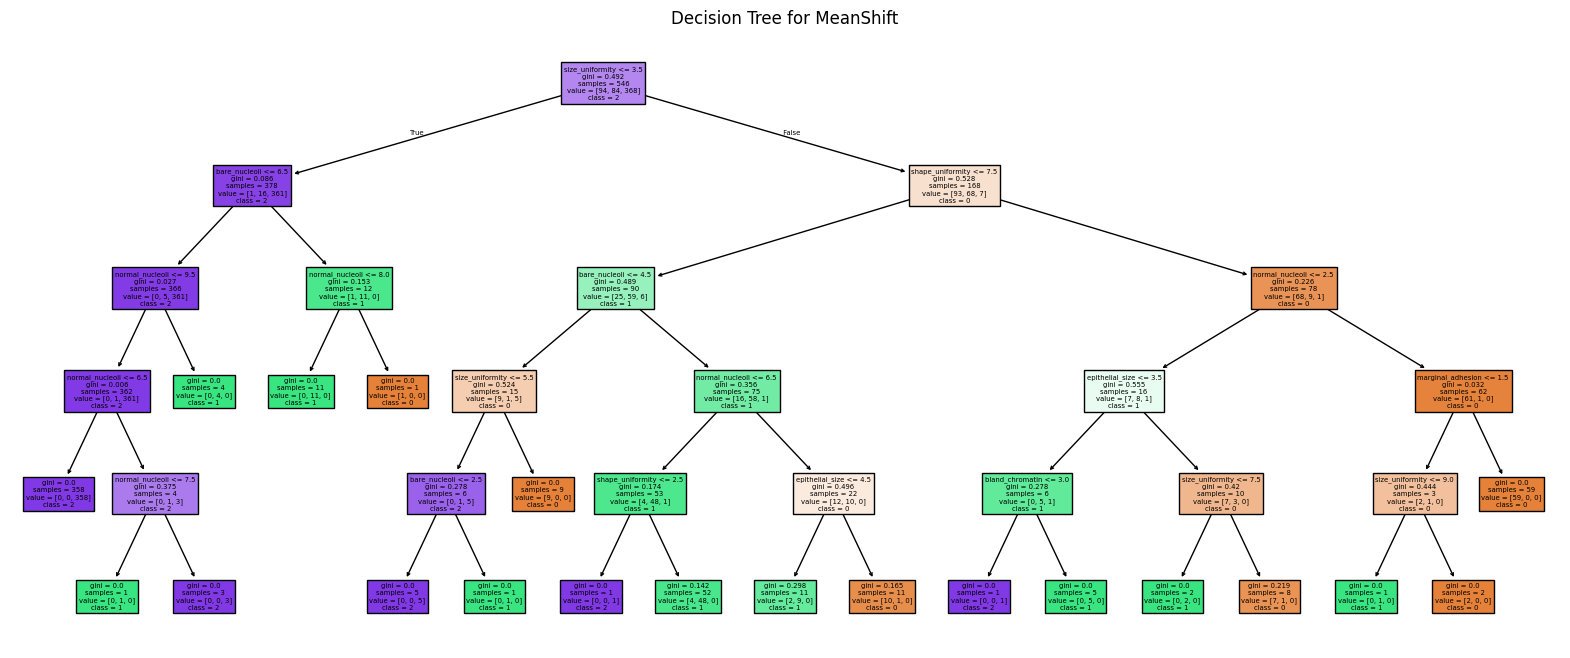

In [25]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=breast_cancer.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [26]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.636] R31: normal_nucleoli > 4.740
			0: 0.636	1: 0.000	2: 0.000	Unc: 0.364

	[0.622] R27: bland_chromatin > 4.921
			0: 0.457	1: 0.391	2: 0.000	Unc: 0.152

	[0.581] R7: size_uniformity > 5.166
			0: 0.555	1: 0.053	2: 0.000	Unc: 0.392

	[0.560] R19: epithelial_size > 4.654
			0: 0.560	1: 0.000	2: 0.000	Unc: 0.440

	[0.535] R15: marginal_adhesion > 4.750
			0: 0.451	1: 0.184	2: 0.000	Unc: 0.365

	[0.488] R22: 3.469 < bare_nucleoli < 5.915
			0: 0.379	1: 0.004	2: 0.245	Unc: 0.372

	[0.488] R11: shape_uniformity > 5.258
			0: 0.488	1: 0.000	2: 0.000	Unc: 0.512

	[0.442] R35: mitoses > 2.653
			0: 0.442	1: 0.000	2: 0.000	Unc: 0.558

	[0.430] R21: 1.022 < bare_nucleoli < 3.469
			0: 0.244	1: 0.000	2: 0.515	Unc: 0.241

Most important rules for class 1

	[0.680] R23: bare_nucleoli > 5.915
			0: 0.000	1: 0.680	2: 0.000	Unc: 0.320

	[0.636] R26: 3.315 < bland_chromatin < 4.921
			0: 0.078	1: 0.599	2: 0.000	Unc: 0.324

	[0.611] R34: 1.553 < mito